<a href="https://colab.research.google.com/github/RaminTK/Job-Shop/blob/main/RL_JobShop_Aug_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
Episode 0: Best=110 (ep 0), Recent Avg=110.0, ε=1.000


/tmp/ipython-input-1751246647.py:185: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor([e[0] for e in batch])


Episode 10: Best=72 (ep 10), Recent Avg=90.8, ε=0.984

 Best makespan: 72

 Train time: 10.02s


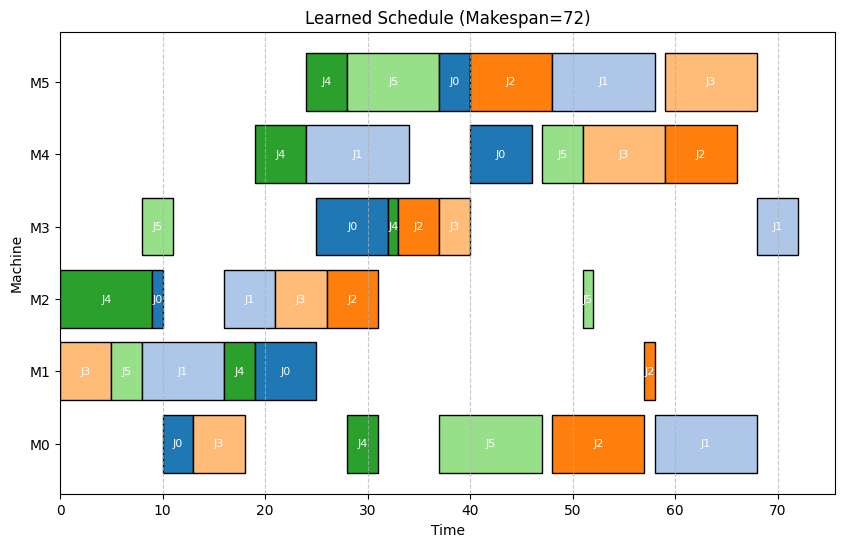

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import time

def now(): return time.perf_counter()

def sync():
    if torch.cuda.is_available():
        torch.cuda.synchronize()

# ---------------- CONFIG ----------------
device = torch.device("cpu")
print(f"Using device: {device}")

# ---------------- ENVIRONMENT ----------------
class JobShopEnvironment:
    def __init__(self, jobs_data):
        self.jobs_data = jobs_data
        self.n_jobs = len(jobs_data)
        self.n_machines = len(jobs_data[0])
        self.optimal_target = 55  # Known optimal for FT06
        self.reset()

    def reset(self):
        self.machine_times = [0] * self.n_machines
        self.job_completion_times = [0] * self.n_jobs
        self.job_progress = [0] * self.n_jobs
        self.total_operations = 0
        self.max_operations = self.n_jobs * self.n_machines
        self.policy_seq = []
        return self.get_state()

    def get_valid_actions(self):
        return [job_id for job_id in range(self.n_jobs)
                if self.job_progress[job_id] < self.n_machines]

    def get_state(self):
        state = []
        progress = self.total_operations / self.max_operations
        state.append(progress)

        current_makespan = max(self.machine_times) if self.machine_times else 0
        state.append(current_makespan / 200.0)

        total_work = sum(self.machine_times)
        if total_work > 0:
            machine_util = [t / total_work for t in self.machine_times]
        else:
            machine_util = [0] * self.n_machines
        state.extend(machine_util)

        job_ratios = [prog / self.n_machines for prog in self.job_progress]
        state.extend(job_ratios)

        for job_id in range(self.n_jobs):
            if self.job_progress[job_id] < self.n_machines:
                machine, duration = self.jobs_data[job_id][self.job_progress[job_id]]
                machine_available = self.machine_times[machine]
                job_available = self.job_completion_times[job_id]
                wait_time = max(0, machine_available - job_available)
                state.extend([
                    machine / self.n_machines,
                    duration / 20.0,
                    wait_time / 100.0,
                    machine_available / 100.0
                ])
            else:
                state.extend([0, 0, 0, 0])

        if max(self.machine_times) > 0:
            balance = 1.0 - (np.std(self.machine_times) / np.mean(self.machine_times))
        else:
            balance = 1.0
        state.append(balance)

        return np.array(state, dtype=np.float32)

    def step(self, action):
        valid_actions = self.get_valid_actions()
        if not valid_actions or action not in valid_actions:
            return self.get_state(), -100, False

        job_id = action
        operation_idx = self.job_progress[job_id]
        machine, duration = self.jobs_data[job_id][operation_idx]

        prev_makespan = max(self.machine_times)
        prev_machine_balance = np.std(self.machine_times)

        start_time = max(self.machine_times[machine], self.job_completion_times[job_id])
        end_time = start_time + duration

        self.machine_times[machine] = end_time
        self.job_completion_times[job_id] = end_time
        self.job_progress[job_id] += 1
        self.total_operations += 1
        self.policy_seq.append(job_id)

        done = all(progress >= self.n_machines for progress in self.job_progress)

        if done:
            makespan = max(self.machine_times)
            # Strong final reward
            reward = 1000 - (makespan - self.optimal_target) * 20
        else:
            current_makespan = max(self.machine_times)
            makespan_increase = current_makespan - prev_makespan
            current_balance = np.std(self.machine_times)

            progress_reward = 1
            makespan_penalty = -makespan_increase * 0.5
            balance_reward = 2 if current_balance < prev_machine_balance else -1
            makespan_penalty_abs = -current_makespan * 0.01

            reward = progress_reward + makespan_penalty + balance_reward + makespan_penalty_abs

        return self.get_state(), reward, done

    def get_makespan(self):
        return max(self.machine_times)

# ---------------- Q-NETWORK ----------------
class ImprovedQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.network(x)

# ---------------- AGENT ----------------
class ImprovedDQNAgent:
    def __init__(self, state_dim, action_dim):
        self.q_network = ImprovedQNetwork(state_dim, action_dim)
        self.target_network = ImprovedQNetwork(state_dim, action_dim)
        self.optimizer = optim.AdamW(self.q_network.parameters(), lr=0.001, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, patience=50, factor=0.8)

        self.memory = deque(maxlen=20000)
        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.99995  # slower decay
        self.epsilon_min = 0.05
        self.update_target_freq = 100
        self.update_count = 0

        self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, valid_actions):
        if not valid_actions:
            return 0
        if random.random() < self.epsilon:
            return random.choice(valid_actions)
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.q_network(state_tensor)[0]
            masked_q_values = q_values.clone()
            for i in range(len(q_values)):
                if i not in valid_actions:
                    masked_q_values[i] = -1e9
            return masked_q_values.argmax().item()

    def train(self):
        if len(self.memory) < self.batch_size:
            return None
        batch = random.sample(self.memory, self.batch_size)
        states = torch.FloatTensor([e[0] for e in batch])
        actions = torch.LongTensor([e[1] for e in batch])
        rewards = torch.FloatTensor([e[2] for e in batch])
        next_states = torch.FloatTensor([e[3] for e in batch])
        dones = torch.BoolTensor([e[4] for e in batch])

        current_q = self.q_network(states).gather(1, actions.unsqueeze(1))

        with torch.no_grad():
            next_actions = self.q_network(next_states).argmax(1)
            next_q = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            target_q = rewards + self.gamma * next_q * ~dones

        loss = nn.SmoothL1Loss()(current_q.squeeze(), target_q)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=10)
        self.optimizer.step()

        self.update_count += 1
        if self.update_count % self.update_target_freq == 0:
            self.update_target_network()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()

# ---------------- TRAINING ----------------
def train_improved_rl(jobs_data, episodes=1500):
    env = JobShopEnvironment(jobs_data)
    state_dim = len(env.get_state())
    action_dim = env.n_jobs
    agent = ImprovedDQNAgent(state_dim, action_dim)

    rewards_history, makespan_history, loss_history = [], [], []
    best_makespan = float('inf')
    best_episode = 0
    best_policy_seq = []

    for episode in range(episodes):
        state = env.reset()
        total_reward, done, step_count = 0, False, 0

        while not done and step_count < 200:
            valid_actions = env.get_valid_actions()
            action = agent.choose_action(state, valid_actions)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            step_count += 1

            if len(agent.memory) > agent.batch_size:
                loss = agent.train()
                if loss is not None:
                    loss_history.append(loss)
                    if episode % 5 == 0:
                        agent.scheduler.step(loss)

        makespan = env.get_makespan()
        rewards_history.append(total_reward)
        makespan_history.append(makespan)

        if makespan < best_makespan:
            best_makespan = makespan
            best_episode = episode
            best_policy_seq = env.policy_seq.copy()
            if best_makespan <= env.optimal_target:
                print(f"🎉 OPTIMAL FOUND at episode {episode}, makespan={best_makespan}")
                break

        if episode % 10 == 0:
            recent_avg = np.mean(makespan_history[-50:]) if len(makespan_history) >= 50 else np.mean(makespan_history)
            print(f"Episode {episode}: Best={best_makespan} (ep {best_episode}), Recent Avg={recent_avg:.1f}, ε={agent.epsilon:.3f}")

    return agent, best_makespan, best_policy_seq, makespan_history, loss_history

# ---------------- GANTT CHART ----------------
def plot_gantt(seq, jobs_data, best_makespan):
    n_jobs = len(jobs_data)
    n_machines = len(jobs_data[0])
    ops_per_job = len(jobs_data[0])
    machine_times = [0] * n_machines
    job_times = [0] * n_jobs
    op_indices = [0] * n_jobs
    schedule = []

    for job in seq:
        if op_indices[job] >= ops_per_job:
            continue
        op_idx = op_indices[job]
        machine, duration = jobs_data[job][op_idx]
        start = max(machine_times[machine], job_times[job])
        finish = start + duration
        schedule.append((job, machine, start, finish))
        machine_times[machine] = finish
        job_times[job] = finish
        op_indices[job] += 1

    fig, ax = plt.subplots(figsize=(10, 6))
    colors = plt.cm.tab20.colors
    for job_id, machine, start, finish in schedule:
        ax.barh(machine, finish - start, left=start, color=colors[job_id % len(colors)], edgecolor='black')
        ax.text(start + (finish - start)/2, machine, f"J{job_id}", va='center', ha='center', color='white', fontsize=8)

    ax.set_yticks(range(n_machines))
    ax.set_yticklabels([f"M{m}" for m in range(n_machines)])
    ax.set_xlabel("Time")
    ax.set_ylabel("Machine")
    ax.set_title(f"Learned Schedule (Makespan={best_makespan})")
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.show()




# ---------------- MAIN ----------------
if __name__ == "__main__":
    jobs_data = [
        [(2,1),(0,3),(1,6),(3,7),(5,3),(4,6)],
        [(1,8),(2,5),(4,10),(5,10),(0,10),(3,4)],
        [(2,5),(3,4),(5,8),(0,9),(1,1),(4,7)],
        [(1,5),(0,5),(2,5),(3,3),(4,8),(5,9)],
        [(2,9),(1,3),(4,5),(5,4),(0,3),(3,1)],
        [(1,3),(3,3),(5,9),(0,10),(4,4),(2,1)],
    ]
    t0 = now()
    agent, best_makespan, best_policy_seq, makespan_history, loss_history = train_improved_rl(jobs_data, episodes=20)
    print(f"\n Best makespan: {best_makespan}")
    train_seconds = now() - t0
    print(f"\n Train time: {train_seconds:.2f}s")
    if best_policy_seq:
        plot_gantt(best_policy_seq, jobs_data, best_makespan)

Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import time

CONFIG

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


ENVIRONMENT

In [17]:
class JobShopEnvironment:
    def __init__(self, jobs_data):
        self.jobs_data = jobs_data
        self.n_jobs = len(jobs_data)
        self.n_machines = len(jobs_data[0])
        self.optimal_target = 55
        self.reset()

    def reset(self):
        self.machine_times = [0] * self.n_machines
        self.job_completion_times = [0] * self.n_jobs
        self.job_progress = [0] * self.n_jobs
        self.total_operations = 0
        self.max_operations = self.n_jobs * self.n_machines
        self.policy_seq = []
        return self.get_state()

    def get_valid_actions(self):
        return [job_id for job_id in range(self.n_jobs)
                if self.job_progress[job_id] < self.n_machines]

    def get_state(self):
        state = []
        progress = self.total_operations / self.max_operations
        state.append(progress)

        current_makespan = max(self.machine_times) if self.machine_times else 0
        state.append(current_makespan / 200.0)

        total_work = sum(self.machine_times)
        if total_work > 0:
            machine_util = [t / total_work for t in self.machine_times]
        else:
            machine_util = [0] * self.n_machines
        state.extend(machine_util)

        job_ratios = [prog / self.n_machines for prog in self.job_progress]
        state.extend(job_ratios)

        for job_id in range(self.n_jobs):
            if self.job_progress[job_id] < self.n_machines:
                machine, duration = self.jobs_data[job_id][self.job_progress[job_id]]
                machine_available = self.machine_times[machine]
                job_available = self.job_completion_times[job_id]
                wait_time = max(0, machine_available - job_available)
                state.extend([
                    machine / self.n_machines,
                    duration / 20.0,
                    wait_time / 100.0,
                    machine_available / 100.0
                ])
            else:
                state.extend([0, 0, 0, 0])

        if max(self.machine_times) > 0:
            balance = 1.0 - (np.std(self.machine_times) / np.mean(self.machine_times))
        else:
            balance = 1.0
        state.append(balance)

        return np.array(state, dtype=np.float32)

    def step(self, action):
        valid_actions = self.get_valid_actions()
        if not valid_actions or action not in valid_actions:
            return self.get_state(), -100, False

        job_id = action
        operation_idx = self.job_progress[job_id]
        machine, duration = self.jobs_data[job_id][operation_idx]

        prev_makespan = max(self.machine_times)
        prev_machine_balance = np.std(self.machine_times)

        start_time = max(self.machine_times[machine], self.job_completion_times[job_id])
        end_time = start_time + duration

        self.machine_times[machine] = end_time
        self.job_completion_times[job_id] = end_time
        self.job_progress[job_id] += 1
        self.total_operations += 1
        self.policy_seq.append(job_id)

        done = all(progress >= self.n_machines for progress in self.job_progress)

        if done:
            makespan = max(self.machine_times)
            # Strong final reward
            reward = 1000 - (makespan - self.optimal_target) * 20
        else:
            current_makespan = max(self.machine_times)
            makespan_increase = current_makespan - prev_makespan
            current_balance = np.std(self.machine_times)

            progress_reward = 1
            makespan_penalty = -makespan_increase * 0.5
            balance_reward = 2 if current_balance < prev_machine_balance else -1
            makespan_penalty_abs = -current_makespan * 0.01

            reward = progress_reward + makespan_penalty + balance_reward + makespan_penalty_abs

        return self.get_state(), reward, done

    def get_makespan(self):
        return max(self.machine_times)

Q-NETWORK

In [18]:
class ImprovedQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.network(x)

AGENT

In [19]:
class ImprovedDQNAgent:
    def __init__(self, state_dim, action_dim):
        self.q_network = ImprovedQNetwork(state_dim, action_dim).to(device)
        self.target_network = ImprovedQNetwork(state_dim, action_dim).to(device)
        self.optimizer = optim.AdamW(self.q_network.parameters(), lr=0.001, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, patience=50, factor=0.8)

        self.memory = deque(maxlen=20000)
        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.99995  # slower decay
        self.epsilon_min = 0.05
        self.update_target_freq = 100
        self.update_count = 0

        self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, valid_actions):
        if not valid_actions:
            return 0
        if random.random() < self.epsilon:
            return random.choice(valid_actions)
        with torch.no_grad():
            # state_tensor = torch.FloatTensor(state).unsqueeze(0)
            state_tensor = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            q_values = self.q_network(state_tensor)[0]
            masked_q_values = q_values.clone()
            for i in range(len(q_values)):
                if i not in valid_actions:
                    masked_q_values[i] = -1e9
            return masked_q_values.argmax().item()

    def train(self):
        if len(self.memory) < self.batch_size:
            return None
        batch = random.sample(self.memory, self.batch_size)
        # states = torch.FloatTensor([e[0] for e in batch])
        # actions = torch.LongTensor([e[1] for e in batch])
        # rewards = torch.FloatTensor([e[2] for e in batch])
        # next_states = torch.FloatTensor([e[3] for e in batch])
        # dones = torch.BoolTensor([e[4] for e in batch])

        states = torch.as_tensor([e[0] for e in batch], dtype=torch.float32, device=device)
        actions = torch.as_tensor([e[1] for e in batch], dtype=torch.long, device=device)
        rewards = torch.as_tensor([e[2] for e in batch], dtype=torch.float32, device=device)
        next_states = torch.as_tensor([e[3] for e in batch], dtype=torch.float32, device=device)
        dones = torch.as_tensor([e[4] for e in batch], dtype=torch.bool, device=device)


        current_q = self.q_network(states).gather(1, actions.unsqueeze(1))

        with torch.no_grad():
            next_actions = self.q_network(next_states).argmax(1)
            next_q = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            target_q = rewards + self.gamma * next_q * ~dones

        loss = nn.SmoothL1Loss()(current_q.squeeze(), target_q)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=10)
        self.optimizer.step()

        self.update_count += 1
        if self.update_count % self.update_target_freq == 0:
            self.update_target_network()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()


TRAINING

In [20]:
def train_improved_rl(jobs_data, episodes=1500):
    env = JobShopEnvironment(jobs_data)
    state_dim = len(env.get_state())
    action_dim = env.n_jobs
    agent = ImprovedDQNAgent(state_dim, action_dim)

    rewards_history, makespan_history, loss_history = [], [], []
    best_makespan = float('inf')
    best_episode = 0
    best_policy_seq = []

    for episode in range(episodes):
        state = env.reset()
        total_reward, done, step_count = 0, False, 0

        while not done and step_count < 200:
            valid_actions = env.get_valid_actions()
            action = agent.choose_action(state, valid_actions)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            step_count += 1

            if len(agent.memory) > agent.batch_size:
                loss = agent.train()
                if loss is not None:
                    loss_history.append(loss)
                    if episode % 5 == 0:
                        agent.scheduler.step(loss)

        makespan = env.get_makespan()
        rewards_history.append(total_reward)
        makespan_history.append(makespan)

        if makespan < best_makespan:
            best_makespan = makespan
            best_episode = episode
            best_policy_seq = env.policy_seq.copy()
            if best_makespan <= env.optimal_target:
                print(f"🎉 OPTIMAL FOUND at episode {episode}, makespan={best_makespan}")
                break

        if episode % 10 == 0:
            recent_avg = np.mean(makespan_history[-50:]) if len(makespan_history) >= 50 else np.mean(makespan_history)
            print(f"Episode {episode}: Best={best_makespan} (ep {best_episode}), Recent Avg={recent_avg:.1f}, ε={agent.epsilon:.3f}")

    return agent, best_makespan, best_policy_seq, makespan_history, loss_history

GANTT CHART and TIME

In [21]:
def plot_gantt(seq, jobs_data, best_makespan):
    n_jobs = len(jobs_data)
    n_machines = len(jobs_data[0])
    ops_per_job = len(jobs_data[0])
    machine_times = [0] * n_machines
    job_times = [0] * n_jobs
    op_indices = [0] * n_jobs
    schedule = []

    for job in seq:
        if op_indices[job] >= ops_per_job:
            continue
        op_idx = op_indices[job]
        machine, duration = jobs_data[job][op_idx]
        start = max(machine_times[machine], job_times[job])
        finish = start + duration
        schedule.append((job, machine, start, finish))
        machine_times[machine] = finish
        job_times[job] = finish
        op_indices[job] += 1

    fig, ax = plt.subplots(figsize=(10, 6))
    colors = plt.cm.tab20.colors
    for job_id, machine, start, finish in schedule:
        ax.barh(machine, finish - start, left=start, color=colors[job_id % len(colors)], edgecolor='black')
        ax.text(start + (finish - start)/2, machine, f"J{job_id}", va='center', ha='center', color='white', fontsize=8)

    ax.set_yticks(range(n_machines))
    ax.set_yticklabels([f"M{m}" for m in range(n_machines)])
    ax.set_xlabel("Time")
    ax.set_ylabel("Machine")
    ax.set_title(f"Learned Schedule (Makespan={best_makespan})")
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.show()



def now(): return time.perf_counter()

def sync():
    if torch.cuda.is_available():
        torch.cuda.synchronize()

MAIN

Episode 0: Best=117 (ep 0), Recent Avg=117.0, ε=1.000
Episode 10: Best=80 (ep 10), Recent Avg=97.4, ε=0.984
Episode 20: Best=73 (ep 17), Recent Avg=95.4, ε=0.966
Episode 30: Best=71 (ep 21), Recent Avg=94.6, ε=0.949
Episode 40: Best=70 (ep 35), Recent Avg=94.1, ε=0.932

 Best makespan: 70

 Train time: 6.83s


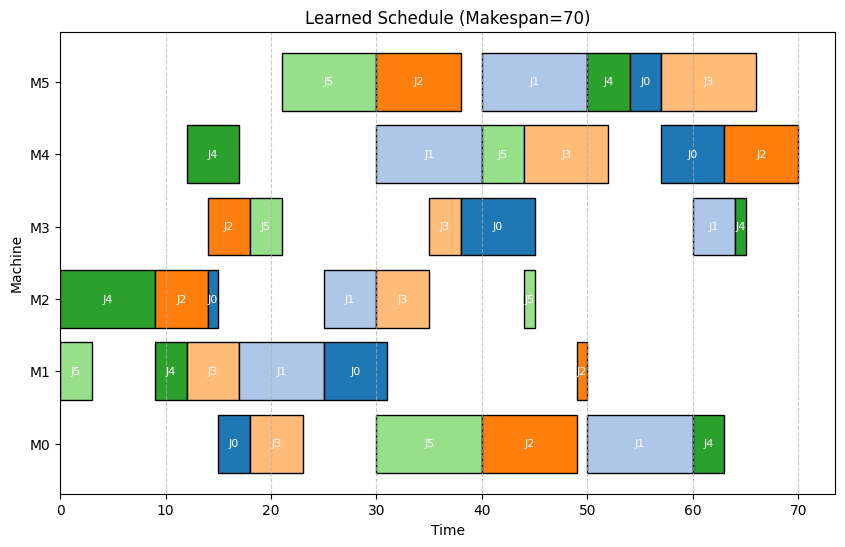

In [23]:
if __name__ == "__main__":
    jobs_data = [
        [(2,1),(0,3),(1,6),(3,7),(5,3),(4,6)],
        [(1,8),(2,5),(4,10),(5,10),(0,10),(3,4)],
        [(2,5),(3,4),(5,8),(0,9),(1,1),(4,7)],
        [(1,5),(0,5),(2,5),(3,3),(4,8),(5,9)],
        [(2,9),(1,3),(4,5),(5,4),(0,3),(3,1)],
        [(1,3),(3,3),(5,9),(0,10),(4,4),(2,1)],
    ]

    # FT20 dataset
    # OPTIMAL SOL = 1165
    # jobs_data = [
    #     [(0,29),(1,9),(2,49),(3,62),(4,44)],
    #     [(0,43),(1,75),(3,69),(2,46),(4,72)],
    #     [(1,91),(0,39),(2,90),(4,12),(3,45)],
    #     [(1,81),(0,71),(4,9),(2,85),(3,22)],
    #     [(2,14),(1,22),(0,26),(3,21),(4,72)],
    #     [(2,84),(1,52),(4,48),(0,47),(3,6)],
    #     [(1,46),(0,61),(2,32),(3,32),(4,30)],
    #     [(2,31),(1,46),(0,32),(3,19),(4,36)],s
    #     [(0,76),(3,76),(2,85),(1,40),(4,26)],
    #     [(1,85),(2,61),(0,64),(3,47),(4,90)],
    #     [(1,78),(3,36),(0,11),(4,56),(2,21)],
    #     [(2,90),(0,11),(1,28),(3,46),(4,30)],
    #     [(0,85),(2,74),(1,10),(3,89),(4,33)],
    #     [(2,95),(0,99),(1,52),(3,98),(4,43)],
    #     [(0,6),(1,61),(4,69),(2,49),(3,53)],
    #     [(1,2),(0,95),(3,72),(4,65),(2,25)],
    #     [(0,37),(2,13),(1,21),(3,89),(4,55)],
    #     [(0,86),(1,74),(4,88),(2,48),(3,79)],
    #     [(1,69),(2,51),(0,11),(3,89),(4,74)],
    #     [(0,13),(1,7),(2,76),(3,52),(4,45)],
    # ]

    t0 = now()

    agent, best_makespan, best_policy_seq, makespan_history, loss_history = train_improved_rl(jobs_data, episodes=50)
    print(f"\n Best makespan: {best_makespan}")
    sync()
    train_seconds = now() - t0
    print(f"\n Train time: {train_seconds:.2f}s")

    if best_policy_seq:
        plot_gantt(best_policy_seq, jobs_data, best_makespan)